<a href="https://colab.research.google.com/github/Tejaswi-Mahadev/RL_HA/blob/main/REINFORCEMENT_LEARNING_LAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EXERCISE - 8**

*Write a Python program to implement the Epsilon-Greedy algorithm for solving a
multi-armed bandit problem with 5 arms. Each arm provides a random reward from a different normal distribution*

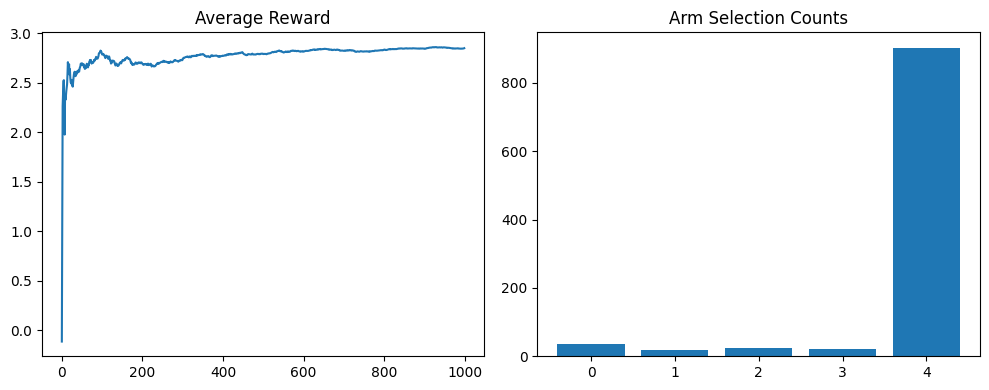

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class MultiArmedBandit:
    def __init__(self, means=[1.0, 2.0, 1.5, 0.5, 3.0], epsilon=0.1):
        self.means = np.array(means)
        self.epsilon = epsilon
        self.q_values = np.zeros(len(means))
        self.counts = np.zeros(len(means))

    def run(self, n_steps=1000):
        rewards = []
        for _ in range(n_steps):
            # Select arm (epsilon-greedy)
            arm = np.random.randint(len(self.means)) if np.random.random() < self.epsilon \
                else np.argmax(self.q_values)

            # Get reward and update estimates
            reward = np.random.normal(self.means[arm], 1.0)
            self.counts[arm] += 1
            self.q_values[arm] += (reward - self.q_values[arm]) / self.counts[arm]
            rewards.append(reward)

        # Plot results
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

        # Running average reward
        ax1.plot(np.cumsum(rewards) / np.arange(1, n_steps + 1))
        ax1.set_title('Average Reward')

        # Final arm distributions
        ax2.bar(range(len(self.means)), self.counts)
        ax2.set_title('Arm Selection Counts')

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    np.random.seed(42)
    bandit = MultiArmedBandit()
    bandit.run()

**EXERCISE - 7**

Implement the Q-Learning algorithm for the FrozenLake-v1
environment (OpenAI Gym). Display the learned Q-table and
visualize the optimal policy for the environment.

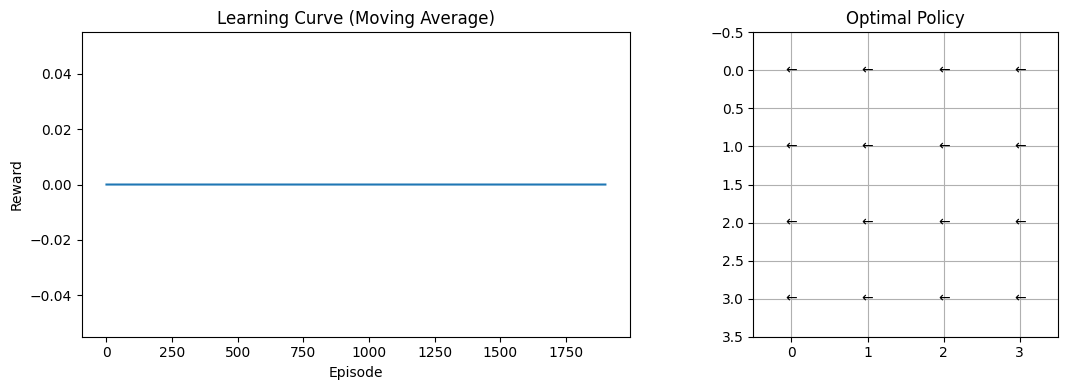

In [4]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

def train_q_learning(env, episodes=2000, alpha=0.1, gamma=0.99, epsilon=0.1):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []

    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Epsilon-greedy action selection
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            # Take action and observe result
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Q-learning update
            Q[state, action] = Q[state, action] + alpha * (
                reward + gamma * np.max(Q[next_state]) - Q[state, action])

            state = next_state
            total_reward += reward

        rewards.append(total_reward)

    return Q, rewards

def plot_results(Q, rewards):
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot learning curve
    ax1.plot(np.convolve(rewards, np.ones(100)/100, mode='valid'))
    ax1.set_title('Learning Curve (Moving Average)')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')

    # Plot policy
    policy = np.argmax(Q, axis=1).reshape(4, 4)
    arrows = ['←', '↓', '→', '↑']
    policy_map = np.array([arrows[a] for a in policy.flat]).reshape(4, 4)

    ax2.imshow(np.zeros((4, 4)), cmap='binary')
    for i in range(4):
        for j in range(4):
            ax2.text(j, i, policy_map[i, j], ha='center', va='center')
    ax2.set_title('Optimal Policy')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    env = gym.make('FrozenLake-v1', render_mode=None)
    Q, rewards = train_q_learning(env)
    plot_results(Q, rewards)
    env.close()

**EXERCISE - 6**

Write a program to estimate the sample complexity required to
achieve a target error ε for a PAC-learning task on a binary dataset.
Plot the error as a function of sample size and validate the PAC
guarantee

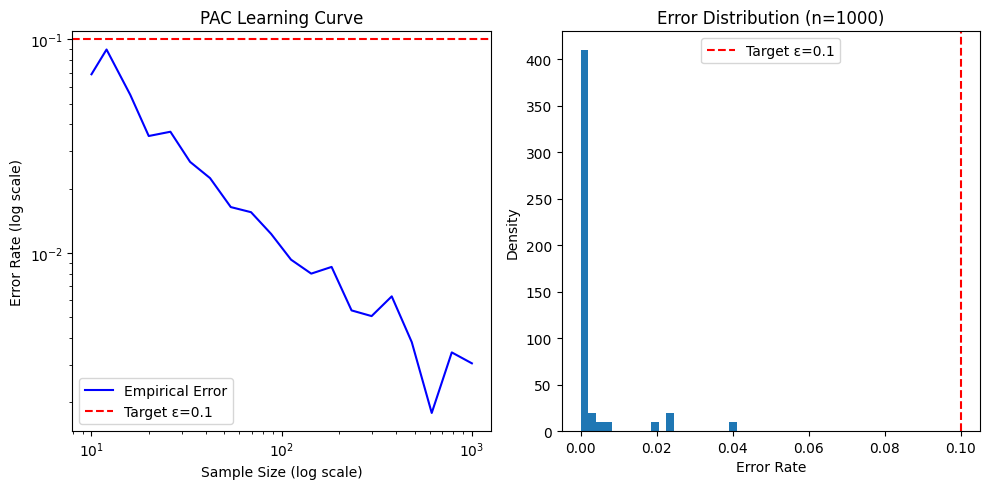

Minimum samples needed: 10


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

def generate_data(n_samples, dimension=2):
    # Generate random binary classification data
    X = np.random.randn(n_samples, dimension)
    # True decision boundary: x1 + x2 > 0
    y = np.where(np.sum(X, axis=1) > 0, 1, -1)
    return X, y

def estimate_sample_complexity(epsilon=0.1, delta=0.1, max_samples=1000, trials=50):
    errors = []
    sample_sizes = np.logspace(1, 3, 20, dtype=int)

    for n in sample_sizes:
        trial_errors = []
        for _ in range(trials):
            # Generate training and test data
            X_train, y_train = generate_data(n)
            X_test, y_test = generate_data(1000)  # Large test set

            # Train perceptron
            clf = Perceptron(max_iter=1000)
            clf.fit(X_train, y_train)

            # Calculate error
            error = 1 - accuracy_score(y_test, clf.predict(X_test))
            trial_errors.append(error)

        errors.append(np.mean(trial_errors))

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.loglog(sample_sizes, errors, 'b-', label='Empirical Error')
    plt.axhline(y=epsilon, color='r', linestyle='--', label=f'Target ε={epsilon}')
    plt.xlabel('Sample Size (log scale)')
    plt.ylabel('Error Rate (log scale)')
    plt.legend()
    plt.title('PAC Learning Curve')

    # Plot error distribution for final sample size
    plt.subplot(1, 2, 2)
    plt.hist(trial_errors, bins=20, density=True)
    plt.axvline(x=epsilon, color='r', linestyle='--', label=f'Target ε={epsilon}')
    plt.xlabel('Error Rate')
    plt.ylabel('Density')
    plt.title(f'Error Distribution (n={sample_sizes[-1]})')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Find minimum samples needed for PAC guarantee
    min_samples = sample_sizes[np.where(np.array(errors) < epsilon)[0][0]]
    return min_samples, errors

if __name__ == "__main__":
    min_samples, errors = estimate_sample_complexity()
    print(f"Minimum samples needed: {min_samples}")

**EXERCISE - 5**

*Write a Python program using Tensor Flow/PyTorch to implement the
Policy Gradient (REINFORCE) algorithm for the CartPole-v1
environment (OpenAI Gym). Train the agent and plot the reward over
1000 episodes.*

Episode 100, Average Reward: 233.20
Episode 200, Average Reward: 282.60
Episode 300, Average Reward: 440.32
Episode 400, Average Reward: 500.00
Episode 500, Average Reward: 467.69
Episode 600, Average Reward: 63.33
Episode 700, Average Reward: 9.55
Episode 800, Average Reward: 9.44
Episode 900, Average Reward: 9.43
Episode 1000, Average Reward: 9.46


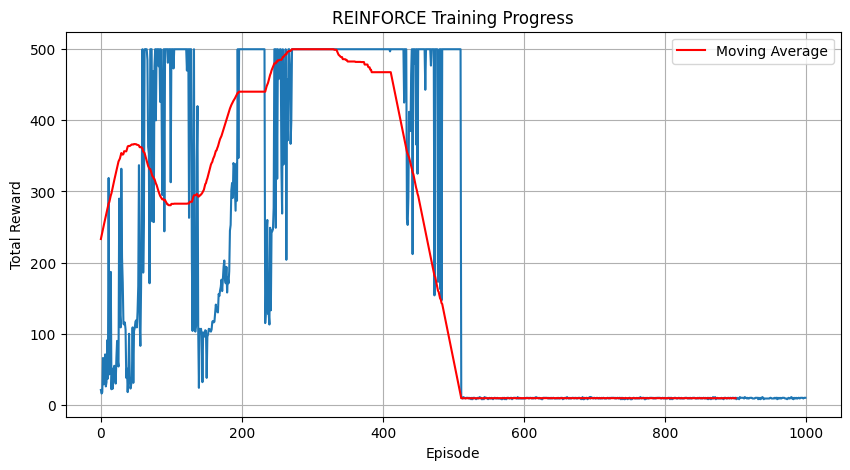

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

class PolicyNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.network(x)

def train_reinforce(env, episodes=1000):
    # Initialize policy network and optimizer
    policy = PolicyNet(env.observation_space.shape[0], env.action_space.n)
    optimizer = optim.Adam(policy.parameters(), lr=0.01)
    rewards_history = []

    for episode in range(episodes):
        state, _ = env.reset()
        episode_rewards = []
        log_probs = []

        # Collect trajectory
        done = False
        while not done:
            # Get action probabilities and sample action
            state_tensor = torch.FloatTensor(state)
            action_probs = policy(state_tensor)
            action_distribution = torch.distributions.Categorical(action_probs)
            action = action_distribution.sample()

            # Take action in environment
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            # Store rewards and log probabilities
            log_probs.append(action_distribution.log_prob(action))
            episode_rewards.append(reward)
            state = next_state

        # Calculate returns and update policy
        returns = []
        G = 0
        for r in reversed(episode_rewards):
            G = r + 0.99 * G
            returns.insert(0, G)
        returns = torch.FloatTensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        # Calculate loss and update policy
        policy_loss = []
        for log_prob, G in zip(log_probs, returns):
            policy_loss.append(-log_prob * G)
        policy_loss = torch.stack(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        # Store total episode reward
        rewards_history.append(sum(episode_rewards))

        # Print progress
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(rewards_history[-100:])
            print(f"Episode {episode + 1}, Average Reward: {avg_reward:.2f}")

    return rewards_history

def plot_results(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.plot(np.convolve(rewards, np.ones(100)/100, mode='valid'),
             'r', label='Moving Average')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('REINFORCE Training Progress')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    env = gym.make('CartPole-v1')
    rewards = train_reinforce(env)
    plot_results(rewards)
    env.close()

**EXERCISE - 4**

*Write a Python program to solve a multi-armed bandit problem using the Median
Elimination algorithm. Compare the number of rounds needed to identify the best arm
with ε = 0.1 and δ = 0.05 versus UCB1*

Median Elimination found arm 0 with 743327 total pulls
UCB1 found arm 0 with 1000 total pulls


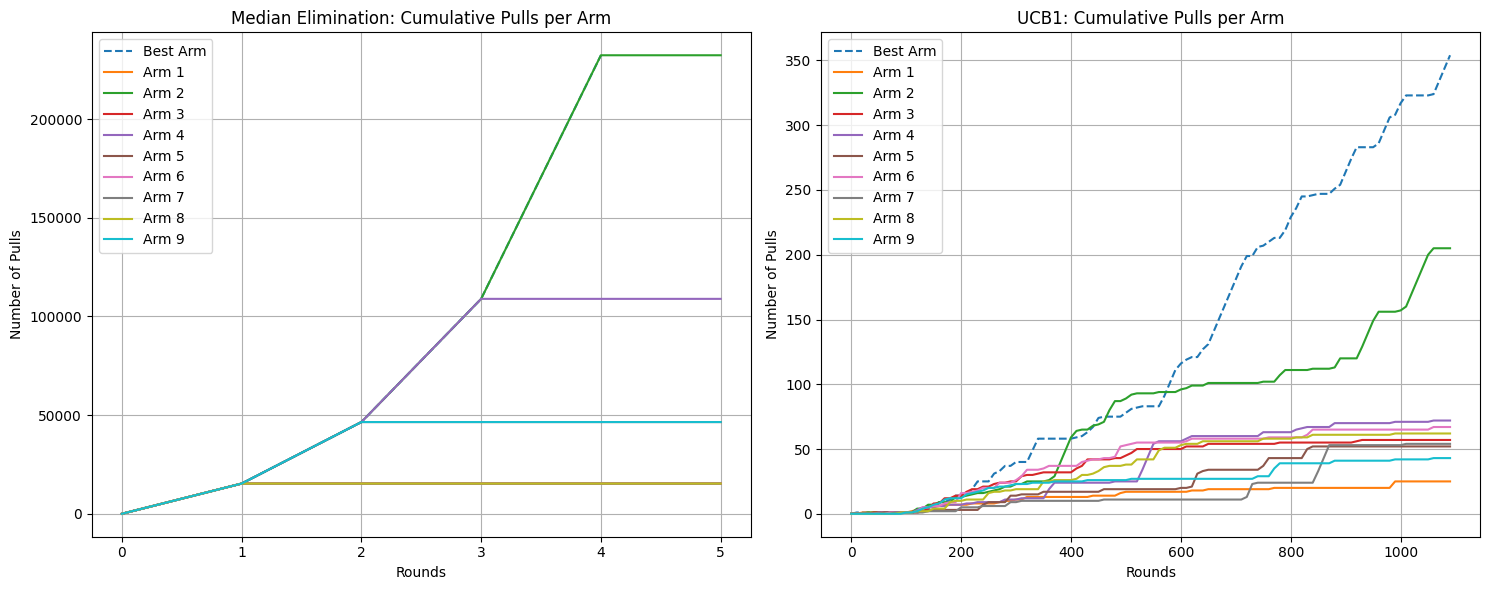

In [9]:
import numpy as np
from math import log, sqrt
import matplotlib.pyplot as plt

class Arm:
    def __init__(self, mean):
        self.mean = mean

    def pull(self):
        return np.random.normal(self.mean, 1.0)

def median_elimination(arms, epsilon=0.1, delta=0.05):
    remaining_arms = list(range(len(arms)))
    total_pulls = 0
    pulls_history = {i: [0] for i in range(len(arms))}
    eps = epsilon/4
    delta_i = delta/2

    while len(remaining_arms) > 1:
        n_i = int(2 * log(3/delta_i) / (eps**2))
        means = []

        for arm_idx in remaining_arms:
            rewards = [arms[arm_idx].pull() for _ in range(n_i)]
            means.append(np.mean(rewards))
            total_pulls += n_i
            pulls_history[arm_idx].append(pulls_history[arm_idx][-1] + n_i)

        median = np.median(means)
        remaining_arms = [arm_idx for idx, arm_idx in enumerate(remaining_arms)
                         if means[idx] >= median]

        # Update history for eliminated arms
        for i in range(len(arms)):
            if i not in remaining_arms:
                pulls_history[i].append(pulls_history[i][-1])

        eps *= 3/4
        delta_i /= 2

    return remaining_arms[0], total_pulls, pulls_history

def ucb1(arms, n_rounds):
    n_arms = len(arms)
    pulls = np.zeros(n_arms)
    values = np.zeros(n_arms)
    pulls_history = {i: [0] for i in range(n_arms)}

    # Initial pulls
    for i in range(n_arms):
        values[i] = arms[i].pull()
        pulls[i] = 1
        for j in range(n_arms):
            pulls_history[j].append(pulls[j])

    # UCB1 rounds
    for t in range(n_arms, n_rounds):
        ucb = values/pulls + np.sqrt(2*log(t)/pulls)
        arm = np.argmax(ucb)
        values[arm] += arms[arm].pull()
        pulls[arm] += 1

        if t % 10 == 0:  # Record every 10th round to reduce data points
            for i in range(n_arms):
                pulls_history[i].append(pulls[i])

    return np.argmax(values/pulls), int(sum(pulls)), pulls_history

def plot_results(me_history, ucb_history, best_arm):
    plt.figure(figsize=(15, 6))

    # Plot Median Elimination
    plt.subplot(1, 2, 1)
    for arm in me_history:
        label = 'Best Arm' if arm == best_arm else f'Arm {arm}'
        style = '--' if arm == best_arm else '-'
        plt.plot(me_history[arm], style, label=label)
    plt.title('Median Elimination: Cumulative Pulls per Arm')
    plt.xlabel('Rounds')
    plt.ylabel('Number of Pulls')
    plt.legend()
    plt.grid(True)

    # Plot UCB1
    plt.subplot(1, 2, 2)
    for arm in ucb_history:
        label = 'Best Arm' if arm == best_arm else f'Arm {arm}'
        style = '--' if arm == best_arm else '-'
        plt.plot(range(0, len(ucb_history[arm])*10, 10), ucb_history[arm], style, label=label)
    plt.title('UCB1: Cumulative Pulls per Arm')
    plt.xlabel('Rounds')
    plt.ylabel('Number of Pulls')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run simulation and create visualization
def run_comparison(n_arms=10):
    # Create arms with one optimal arm
    arms = [Arm(0.8) for _ in range(n_arms)]
    arms[0] = Arm(1.0)  # Best arm

    # Run both algorithms
    me_best, me_pulls, me_history = median_elimination(arms.copy())
    ucb_best, ucb_pulls, ucb_history = ucb1(arms.copy(), 1000)

    # Print results
    print(f"Median Elimination found arm {me_best} with {me_pulls} total pulls")
    print(f"UCB1 found arm {ucb_best} with {ucb_pulls} total pulls")

    # Plot results
    plot_results(me_history, ucb_history, 0)  # 0 is the best arm

if __name__ == "__main__":
    run_comparison()

**EXERCISE -3**

*Develop a Python program to implement a PAC-learning algorithm for a binary
classification task (e.g., classifying points inside/outside a circle). Generate a
synthetic dataset and verify the accuracy within ε = 0.05 and δ = 0.1.*

Required samples: 60
Learned radius: 0.957
Test accuracy: 0.980


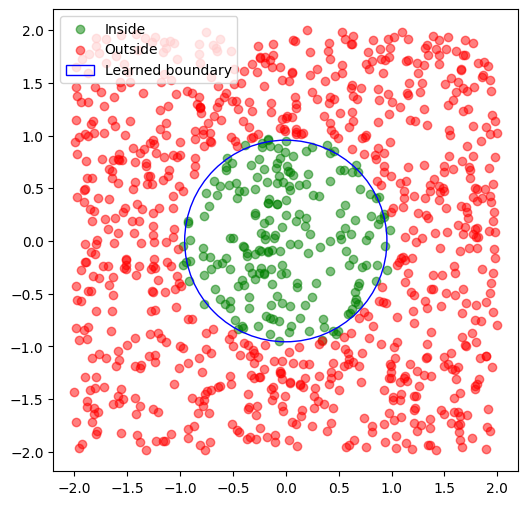

In [10]:
import numpy as np
from math import log
import matplotlib.pyplot as plt

def generate_data(n_samples, radius=1):
    """Generate points and label them based on circle membership"""
    X = np.random.uniform(-2, 2, (n_samples, 2))
    y = (np.linalg.norm(X, axis=1) <= radius).astype(int)
    return X, y

class CirclePACLearner:
    def __init__(self, epsilon=0.05, delta=0.1):
        self.epsilon = epsilon
        self.delta = delta
        self.radius = None

    def compute_sample_size(self):
        """Compute PAC sample size requirement"""
        return int(np.ceil((1/self.epsilon) * (log(1/self.delta) + log(2))))

    def fit(self, X, y):
        """Learn circle radius from data"""
        # Find radius that minimizes classification error
        distances = np.linalg.norm(X, axis=1)
        best_error = float('inf')

        for d in sorted(distances):
            pred = (distances <= d).astype(int)
            error = np.mean(pred != y)
            if error < best_error:
                best_error = error
                self.radius = d

    def predict(self, X):
        """Predict class labels"""
        return (np.linalg.norm(X, axis=1) <= self.radius).astype(int)

# Run demonstration
def run_pac_demo():
    # Initialize learner
    learner = CirclePACLearner(epsilon=0.05, delta=0.1)
    n_samples = learner.compute_sample_size()

    # Generate and split data
    X, y = generate_data(n_samples)
    X_test, y_test = generate_data(1000)  # Test set

    # Train and evaluate
    learner.fit(X, y)
    accuracy = np.mean(learner.predict(X_test) == y_test)

    print(f"Required samples: {n_samples}")
    print(f"Learned radius: {learner.radius:.3f}")
    print(f"Test accuracy: {accuracy:.3f}")

    # Visualize results
    plt.figure(figsize=(6, 6))
    plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], c='g', alpha=0.5, label='Inside')
    plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], c='r', alpha=0.5, label='Outside')
    circle = plt.Circle((0, 0), learner.radius, fill=False, color='b', label='Learned boundary')
    plt.gca().add_artist(circle)
    plt.legend()
    plt.axis('equal')
    plt.show()

if __name__ == "__main__":
    run_pac_demo()

**EXERCISE - 2**

*Write a Python program to implement the UCB1 algorithm for a 10-arm bandit
problem. Run the program for 2000 rounds and compare the cumulative reward with
an ε-greedy algorithm*

UCB1 total reward: 3170.78
ε-greedy total reward: 2870.96

Best arm mean: 1.64
UCB1 best arm estimate: 1.64
ε-greedy best arm estimate: 1.64


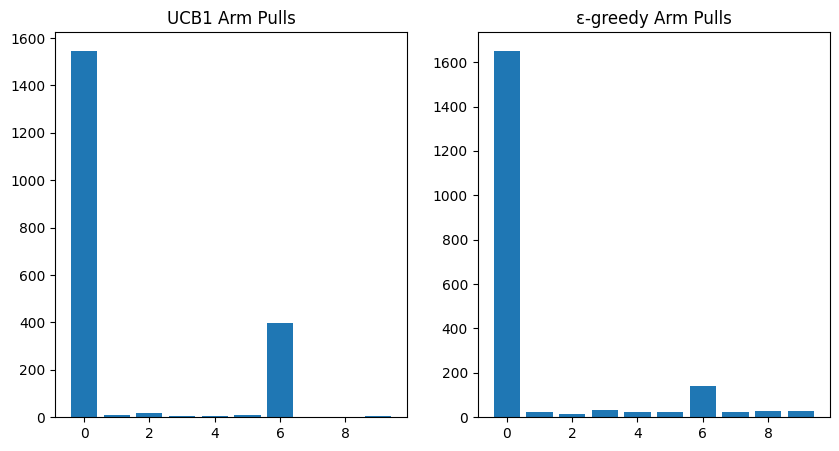

In [11]:
import numpy as np
import matplotlib.pyplot as plt

class Arm:
    def __init__(self, mean):
        self.mean = mean

    def pull(self):
        return np.random.normal(self.mean, 1.0)

def ucb1(arms, n_rounds):
    n_arms = len(arms)
    pulls = np.ones(n_arms)  # Start with 1 to avoid division by zero
    rewards = np.array([arms[i].pull() for i in range(n_arms)])
    cumulative_reward = np.sum(rewards)

    for t in range(n_arms, n_rounds):
        ucb_values = rewards/pulls + np.sqrt(2*np.log(t)/pulls)
        arm = np.argmax(ucb_values)
        reward = arms[arm].pull()
        rewards[arm] += reward
        pulls[arm] += 1
        cumulative_reward += reward

    return cumulative_reward, pulls, rewards/pulls

def epsilon_greedy(arms, n_rounds, epsilon=0.1):
    n_arms = len(arms)
    pulls = np.ones(n_arms)
    rewards = np.array([arms[i].pull() for i in range(n_arms)])
    cumulative_reward = np.sum(rewards)

    for t in range(n_arms, n_rounds):
        if np.random.random() < epsilon:
            arm = np.random.randint(n_arms)
        else:
            arm = np.argmax(rewards/pulls)

        reward = arms[arm].pull()
        rewards[arm] += reward
        pulls[arm] += 1
        cumulative_reward += reward

    return cumulative_reward, pulls, rewards/pulls

# Run comparison
n_arms = 10
n_rounds = 2000
true_means = np.random.normal(0, 1, n_arms)
arms = [Arm(mean) for mean in true_means]

# Run both algorithms
ucb_reward, ucb_pulls, ucb_means = ucb1(arms, n_rounds)
eps_reward, eps_pulls, eps_means = epsilon_greedy(arms, n_rounds)

print(f"UCB1 total reward: {ucb_reward:.2f}")
print(f"ε-greedy total reward: {eps_reward:.2f}")
print(f"\nBest arm mean: {max(true_means):.2f}")
print(f"UCB1 best arm estimate: {max(ucb_means):.2f}")
print(f"ε-greedy best arm estimate: {max(eps_means):.2f}")

# Plot arm pulls
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(range(n_arms), ucb_pulls)
plt.title('UCB1 Arm Pulls')
plt.subplot(1, 2, 2)
plt.bar(range(n_arms), eps_pulls)
plt.title('ε-greedy Arm Pulls')
plt.show()

**EXERCISE - 1**

*Write a program in Python to solve a Grid world problem using epsilon greedy
algorithm of multiarm bandit problem*


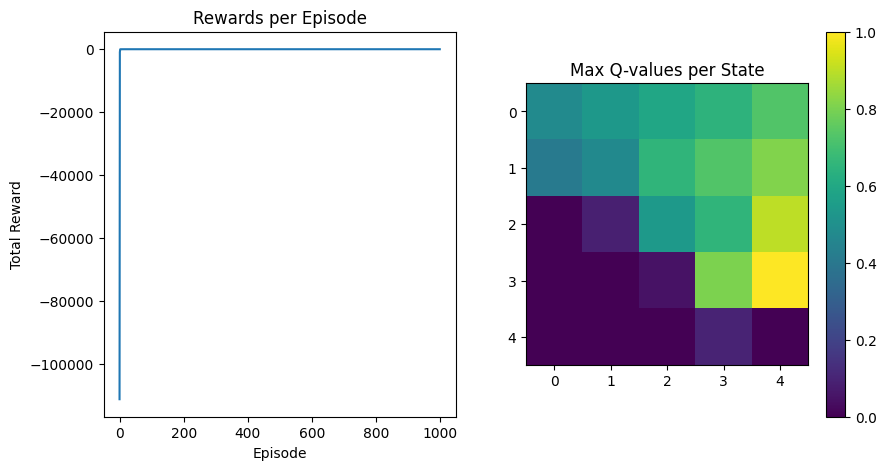

Optimal path: [[0, 0], [0, 1], [0, 2], [1, 2], [1, 3], [1, 4], [2, 4], [3, 4], [4, 4]]


In [1]:
import numpy as np
import matplotlib.pyplot as plt

class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.state = [0, 0]  # Start at top-left
        self.goal = [size-1, size-1]  # Goal at bottom-right

        # Create obstacles (random negative rewards)
        self.grid = np.zeros((size, size))
        n_obstacles = size * 2
        obstacles = np.random.randint(0, size, (n_obstacles, 2))
        for x, y in obstacles:
            if [x, y] != [0, 0] and [x, y] != self.goal:
                self.grid[x, y] = -1

        # Set goal reward
        self.grid[self.goal[0], self.goal[1]] = 1

    def reset(self):
        self.state = [0, 0]
        return self.state.copy()

    def step(self, action):
        # Actions: 0=up, 1=right, 2=down, 3=left
        moves = [[-1, 0], [0, 1], [1, 0], [0, -1]]
        new_state = [
            self.state[0] + moves[action][0],
            self.state[1] + moves[action][1]
        ]

        # Check boundaries
        if 0 <= new_state[0] < self.size and 0 <= new_state[1] < self.size:
            self.state = new_state

        reward = self.grid[self.state[0], self.state[1]]
        done = (self.state == self.goal)
        return self.state.copy(), reward, done

class EpsilonGreedyAgent:
    def __init__(self, state_size, n_actions, epsilon=0.1):
        self.q_table = np.zeros((state_size, state_size, n_actions))
        self.epsilon = epsilon
        self.n_actions = n_actions

    def get_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        return np.argmax(self.q_table[state[0], state[1]])

    def update(self, state, action, reward, next_state, alpha=0.1):
        old_value = self.q_table[state[0], state[1], action]
        next_max = np.max(self.q_table[next_state[0], next_state[1]])
        new_value = (1 - alpha) * old_value + alpha * (reward + 0.9 * next_max)
        self.q_table[state[0], state[1], action] = new_value

def train_and_visualize(episodes=1000):
    env = GridWorld()
    agent = EpsilonGreedyAgent(env.size, 4)
    rewards_history = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.get_action(state)
            next_state, reward, done = env.step(action)
            agent.update(state, action, reward, next_state)
            state = next_state
            total_reward += reward

            if done:
                rewards_history.append(total_reward)
                break

    # Plot rewards
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards_history)
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

    # Plot final Q-values
    plt.subplot(1, 2, 2)
    plt.imshow(np.max(agent.q_table, axis=2))
    plt.colorbar()
    plt.title('Max Q-values per State')
    plt.show()

    return env, agent

if __name__ == "__main__":
    env, agent = train_and_visualize()

    # Print optimal path
    state = env.reset()
    path = [state.copy()]
    done = False

    while not done:
        action = np.argmax(agent.q_table[state[0], state[1]])
        state, _, done = env.step(action)
        path.append(state.copy())

    print("Optimal path:", path)